In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
from sklearn.pipeline       import Pipeline
from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing  import OneHotEncoder
from sklearn.linear_model   import LinearRegression
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

data = pd.read_csv("/home/aj/cojects/Methane/data/CA-NV-TX.csv", on_bad_lines='skip')

In [2]:

# Ensure 'datetime' is in the correct format
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the month
data['month'] = data['datetime'].dt.month

# Define a function to map the month to the season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a 'season' column
data['season'] = data['month'].apply(get_season)

# Check the new season column
print(data[['datetime', 'season']].head())
print()
print(data.columns)

                   datetime  season
0 2023-12-01 20:10:23+00:00  Winter
1 2023-12-01 20:10:23+00:00  Winter
2 2023-12-01 20:10:23+00:00  Winter
3 2023-10-27 17:04:16+00:00    Fall
4 2023-10-26 17:52:10+00:00    Fall

Index(['plume_id', 'plume_latitude', 'plume_longitude', 'datetime',
       'ipcc_sector', 'gas', 'emission_cmf_type', 'plume_bounds', 'instrument',
       'mission_phase', 'published_at', 'modified', 'emission_version',
       'processing_software', 'gsd', 'sensitivity_mode', 'off_nadir',
       'emission_auto', 'emission_uncertainty_auto', 'wind_speed_avg_auto',
       'wind_speed_std_auto', 'wind_direction_avg_auto',
       'wind_direction_std_auto', 'wind_source_auto', 'platform', 'provider',
       'plume_tif', 'plume_png', 'con_tif', 'rgb_tif', 'rgb_png', 'month',
       'season'],
      dtype='object')


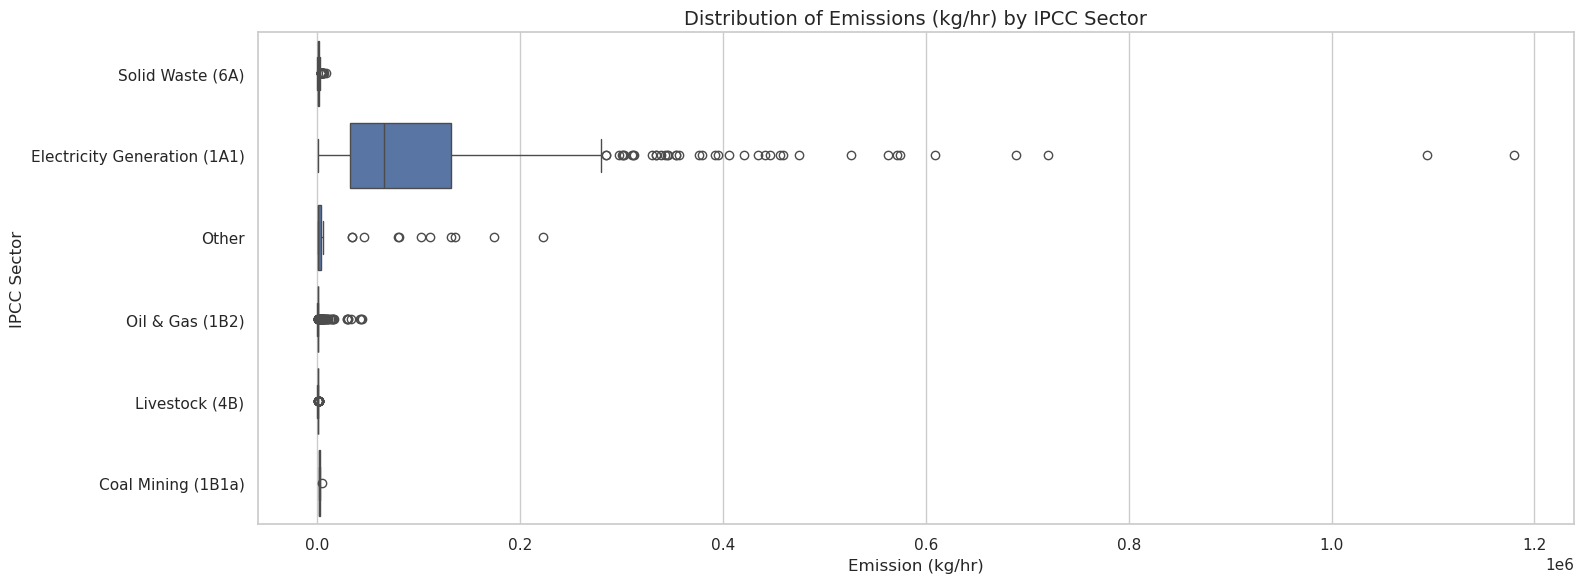

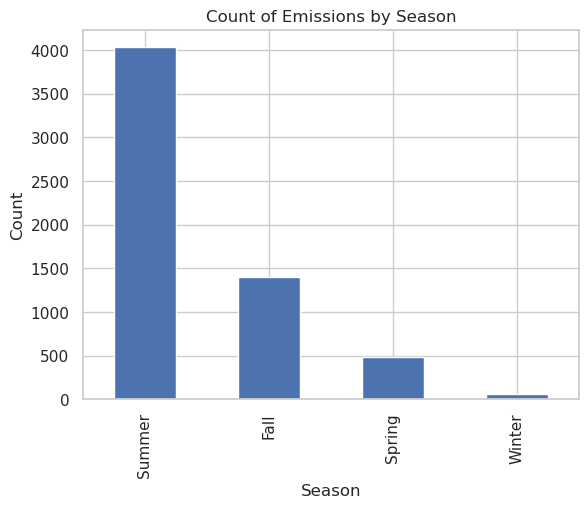

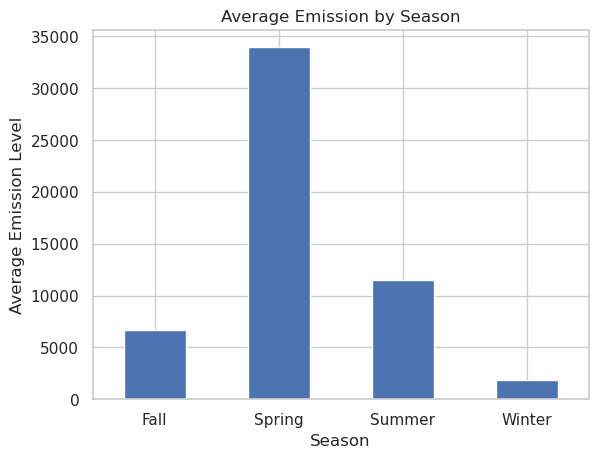

In [3]:

# Drop missing values in relevant columns
df = data.dropna(subset=["ipcc_sector", "emission_auto"])

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure with extended width
plt.figure(figsize=(16, 6))

# Horizontal boxplot
sns.boxplot(
    data=df,
    x="emission_auto",
    y="ipcc_sector",
    orient="h",
    showfliers=True  # Show outliers (can set to False if it's too noisy)
)

# Add labels and title
plt.title("Distribution of Emissions (kg/hr) by IPCC Sector", fontsize=14)
plt.xlabel("Emission (kg/hr)", fontsize=12)
plt.ylabel("IPCC Sector", fontsize=12)

# Optional: Set x-axis limits or use log scale if desired
# plt.xlim(0, 10000)  # Example: limit x-axis if one outlier dominates
# plt.xscale('log')  # If emissions vary across several orders of magnitude

plt.tight_layout()
plt.show()


# Plot the count of emissions per season
data['season'].value_counts().plot(kind='bar', title='Count of Emissions by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

# Print out all column names in your dataset to find the correct one for emissions

# If emission levels are numeric, plot the average emission by season
# Assuming 'emission_level' is a column containing the emission quantity (you may need to adjust based on your data)
# Adjust the column name if necessary
data_grouped = data.groupby('season')['emission_auto'].mean()

# Plot the average emissions by season
data_grouped.plot(kind='bar', title='Average Emission by Season')

# Set labels and title for clarity
plt.xlabel('Season')
plt.ylabel('Average Emission Level')
plt.xticks(rotation=0)  # This will keep the season names horizontal for better readability
plt.show()


Index(['season', 'gas', 'ipcc_sector', 'wind_speed_avg_auto', 'emission_auto',
       'instrument'],
      dtype='object')

count       4,484.00
mean       14,163.16
std        56,481.25
min             6.60
25%           165.14
50%           328.18
75%           878.65
max     1,180,011.64
Name: emission_auto, dtype: float64


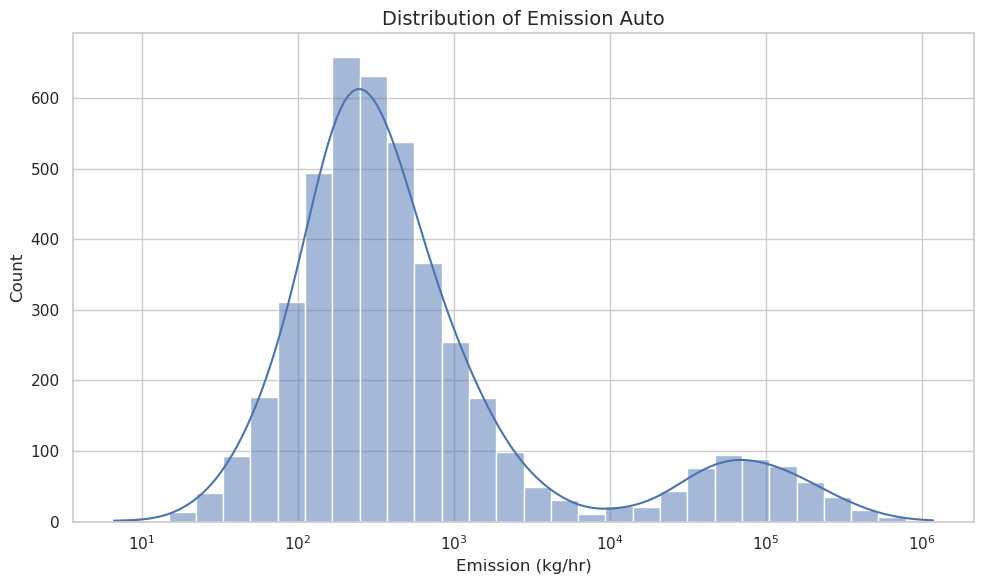

In [4]:
# Select relevant columns
selected_columns = ['season', 'gas', 'ipcc_sector',  'wind_speed_avg_auto', 'emission_auto', 'instrument']

# Remove rows with missing values in important columns
data = data[selected_columns].dropna()

# Check the resulting dataframe
#print(data.head())
print(data.columns)
print()
pd.set_option('display.float_format', '{:,.2f}'.format)
print(data["emission_auto"].describe())

sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=data,
    x="emission_auto",
    bins=30,        # feel free to adjust number of bins
    kde=True,       # add a density curve
    log_scale=True  # optionally plot on a log scale if skewed
)

# Add labels and title
plt.title("Distribution of Emission Auto", fontsize=14)
plt.xlabel("Emission (kg/hr)", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
X = data[["season", "gas", "ipcc_sector", "wind_speed_avg_auto", "instrument"]]
y = data["emission_auto"]

# 3) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22
)

# 4) Common preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"),
     ["season", "gas", "ipcc_sector", "instrument"])
], remainder="passthrough")

# 5a) Linear Regression pipeline
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# 5b) Random Forest pipeline
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=22))
])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# ==============================================================================================================

# 6) Compute errors
#   - MAE
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
#   - MSE & RMSE
mse_lr  = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
#   - Mean Error (bias)
me_lr = np.mean(y_pred_lr - y_test.to_numpy())
me_rf = np.mean(y_pred_rf - y_test.to_numpy())

# 7) Print
print("Linear Regression:")
print(f"  MAE : {mae_lr:,.2f}")
print(f"  MSE : {mse_lr:,.2f}")
print(f"  RMSE: {rmse_lr:,.2f}")
print(f"  Mean Error (bias): {me_lr:,.2f}\n")

print("Random Forest:")
print(f"  MAE : {mae_rf:,.2f}")
print(f"  MSE : {mse_rf:,.2f}")
print(f"  RMSE: {rmse_rf:,.2f}")
print(f"  Mean Error (bias): {me_rf:,.2f}")

Linear Regression:
  MAE : 12,167.21
  MSE : 1,269,960,802.69
  RMSE: 35,636.51
  Mean Error (bias): 2,607.26

Random Forest:
  MAE : 8,021.00
  MSE : 1,169,161,161.06
  RMSE: 34,193.00
  Mean Error (bias): 1,157.39


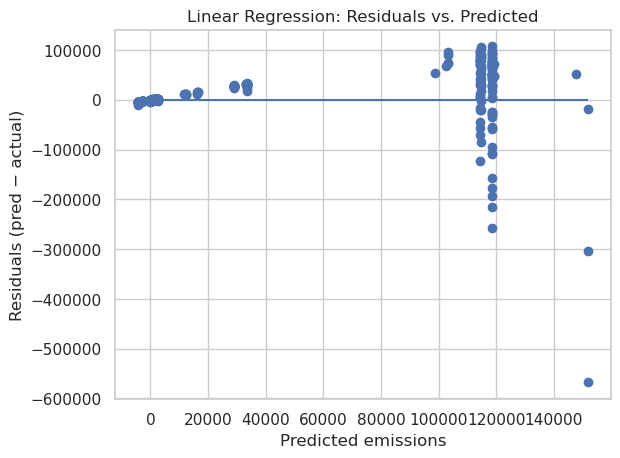

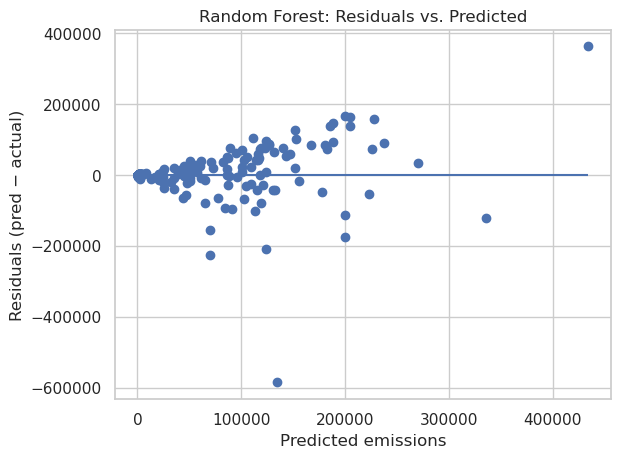

In [6]:
import matplotlib.pyplot as plt

# Compute residuals
residuals_lr = y_pred_lr - y_test
residuals_rf = y_pred_rf - y_test

# Linear Regression residuals
plt.figure()
plt.scatter(y_pred_lr, residuals_lr)
plt.hlines(0, y_pred_lr.min(), y_pred_lr.max())
plt.xlabel("Predicted emissions")
plt.ylabel("Residuals (pred − actual)")
plt.title("Linear Regression: Residuals vs. Predicted")
plt.show()

# Random Forest residuals
plt.figure()
plt.scatter(y_pred_rf, residuals_rf)
plt.hlines(0, y_pred_rf.min(), y_pred_rf.max())
plt.xlabel("Predicted emissions")
plt.ylabel("Residuals (pred − actual)")
plt.title("Random Forest: Residuals vs. Predicted")
plt.show()


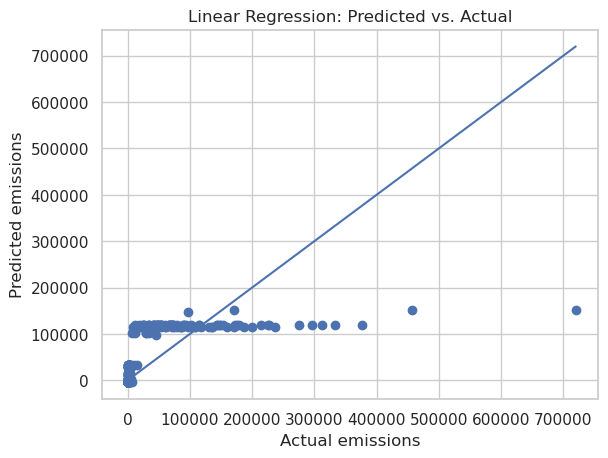

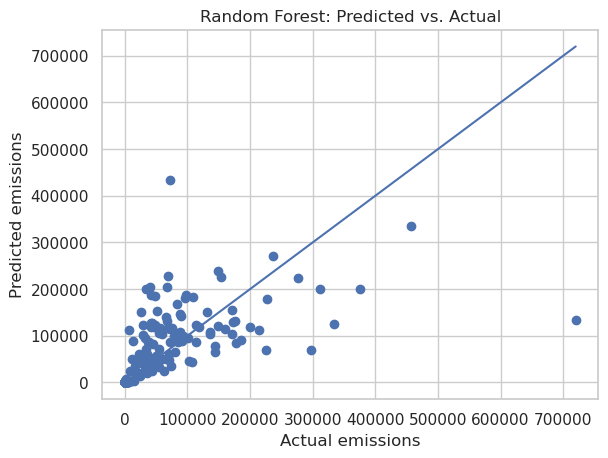

In [7]:
import matplotlib.pyplot as plt

# Linear Regression
plt.figure()
plt.scatter(y_test, y_pred_lr)
# reference line y = x
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Actual emissions")
plt.ylabel("Predicted emissions")
plt.title("Linear Regression: Predicted vs. Actual")
plt.show()

# Random Forest
plt.figure()
plt.scatter(y_test, y_pred_rf)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Actual emissions")
plt.ylabel("Predicted emissions")
plt.title("Random Forest: Predicted vs. Actual")
plt.show()


  season  gas       ipcc_sector  wind_speed_avg_auto  emission_auto instrument
3   Fall  CH4  Solid Waste (6A)                 1.64         995.33        emi
4   Fall  CH4  Solid Waste (6A)                 1.70         888.76        emi
5   Fall  CH4  Solid Waste (6A)                 2.21       1,321.15        emi
6   Fall  CH4  Solid Waste (6A)                 3.64       2,053.67        emi
8   Fall  CH4  Solid Waste (6A)                 4.07       2,714.43        emi

count   3,946.00
mean      531.52
std       815.57
min         6.60
25%       151.80
50%       276.54
75%       556.37
max     9,722.52
Name: emission_auto, dtype: float64


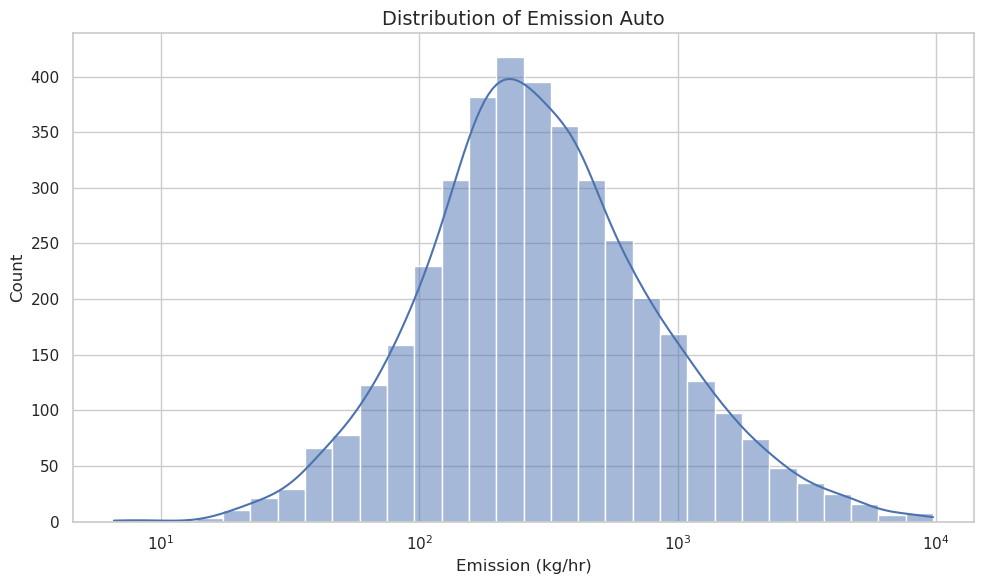

In [8]:
# Option B: drop by index
to_drop = data.index[data["emission_auto"] > 1e4]
data = data.drop(to_drop)
# Check the resulting dataframe
print(data.head())
print()
pd.set_option('display.float_format', '{:,.2f}'.format)
print(data["emission_auto"].describe())

sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=data,
    x="emission_auto",
    bins=30,        # feel free to adjust number of bins
    kde=True,       # add a density curve
    log_scale=True  # optionally plot on a log scale if skewed
)

# Add labels and title
plt.title("Distribution of Emission Auto", fontsize=14)
plt.xlabel("Emission (kg/hr)", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
X = data[["season", "gas", "ipcc_sector", "wind_speed_avg_auto", "instrument"]]
y = data["emission_auto"]

# 3) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22
)

# 4) Common preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"),
     ["season", "gas", "ipcc_sector", "instrument"])
], remainder="passthrough")

# 5a) Linear Regression pipeline
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# 5b) Random Forest pipeline
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=22))
])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

# ==============================================================================================================

# 6) Compute errors
#   - MAE
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
#   - MSE & RMSE
mse_lr  = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
#   - Mean Error (bias)
me_lr = np.mean(y_pred_lr - y_test.to_numpy())
me_rf = np.mean(y_pred_rf - y_test.to_numpy())

# 7) Print
print("Linear Regression:")
print(f"  MAE : {mae_lr:,.2f}")
print(f"  MSE : {mse_lr:,.2f}")
print(f"  RMSE: {rmse_lr:,.2f}")
print(f"  Mean Error (bias): {me_lr:,.2f}\n")

print("Random Forest:")
print(f"  MAE : {mae_rf:,.2f}")
print(f"  MSE : {mse_rf:,.2f}")
print(f"  RMSE: {rmse_rf:,.2f}")
print(f"  Mean Error (bias): {me_rf:,.2f}")

Linear Regression:
  MAE : 1,636.57
  MSE : 1,327,037,380.32
  RMSE: 36,428.52
  Mean Error (bias): -1,267.85

Random Forest:
  MAE : 329.39
  MSE : 332,948.93
  RMSE: 577.02
  Mean Error (bias): 19.57


In [10]:
from sklearn.model_selection import GridSearchCV

# 1) Re-use your existing pipeline_rf (but drop the hard-coded n_estimators & max_depth)
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=22))
])

# 2) Define the grid of hyperparameters
param_grid = {
    # number of trees
    "regressor__n_estimators": [50, 100, 200],
    # maximum depth of each tree
    "regressor__max_depth": [None, 10, 20, 30],
    # minimum number of samples to split an internal node
    "regressor__min_samples_split": [2, 5, 10],
    # fraction or method to select features at each split
    "regressor__max_features": ["auto", "sqrt", 0.5]
}

# 3) Set up GridSearchCV
grid_search = GridSearchCV(
    estimator   = pipeline_rf,
    param_grid  = param_grid,
    cv          = 5,                       # 5-fold
    scoring     = "neg_mean_squared_error",
    n_jobs      = -1,                      # use all CPUs
    verbose     = 2
)

# 4) Run the search on your training data
grid_search.fit(X_train, y_train)

# 5) Inspect the best setting and CV score (MSE is negated internally)
best_params = grid_search.best_params_
best_cv_mse = -grid_search.best_score_
print("Best RF params:", best_params)
print(f"Best 5-fold CV MSE = {best_cv_mse:,.2f}")

# 6) Evaluate that tuned model on your hold-out test set
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
tuned_test_mse = mean_squared_error(y_test, y_pred_tuned)
print(f"Tuned RF Test MSE = {tuned_test_mse:,.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=5, regressor__n_estimators=50; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__max_features=auto,

/home/aj/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
94 fits failed with the following error:
Traceback (most recent call last):
  File "/home/aj/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/aj/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aj/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 473, in fit
    sel

Best RF params: {'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best 5-fold CV MSE = 350,455.03
Tuned RF Test MSE = 272,220.52


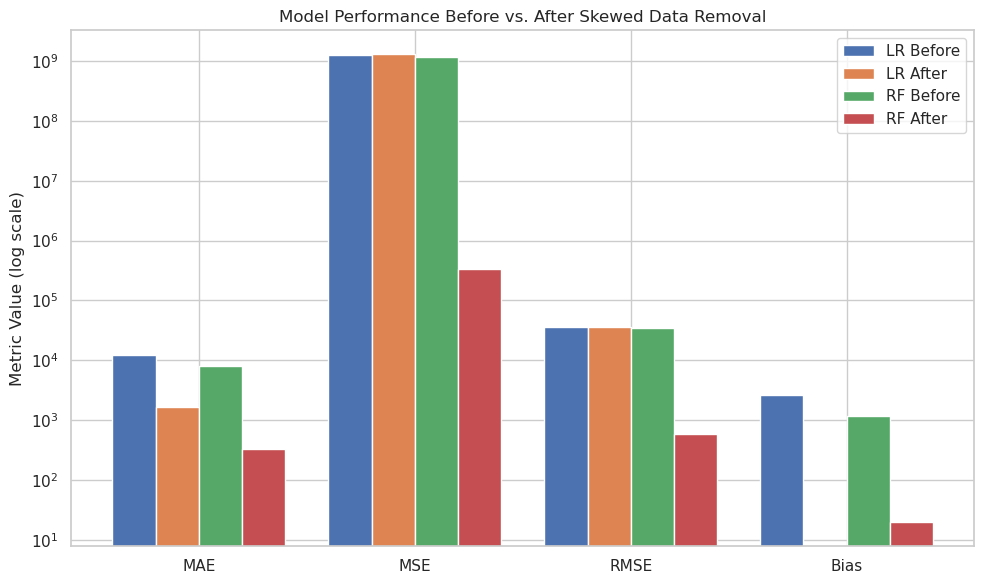

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and values
metrics    = ['MAE', 'MSE', 'RMSE', 'Bias']
lr_before  = [12167.21, 1.2699608e9, 35636.51,  2607.26]
rf_before  = [ 8021.00, 1.1691612e9, 34193.00,  1157.39]
lr_after   = [ 1636.57, 1.3270374e9, 36428.52, -1267.85]
rf_after   = [  329.39, 3.3294893e5,   577.02,    19.57]

x     = np.arange(len(metrics))
w     = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*w, lr_before, w, label='LR Before')
plt.bar(x - 0.5*w, lr_after,  w, label='LR After')
plt.bar(x + 0.5*w, rf_before, w, label='RF Before')
plt.bar(x + 1.5*w, rf_after,  w, label='RF After')

plt.xticks(x, metrics)
plt.yscale('log')
plt.ylabel('Metric Value (log scale)')
plt.title('Model Performance Before vs. After Skewed Data Removal')
plt.legend()
plt.tight_layout()
plt.show()
